In [1]:
import tensorflow as tf
import dirt
import cv2
import menpo3d.io as m3io
import pickle
import numpy as np

from scipy.io import loadmat
from menpo.image import Image
from menpo.shape import PointCloud, TriMesh
from copy import deepcopy
from os.path import join


def ProjectShape(vertex, fR, T, roi_bbox):
    # function in pytorch 3DDFA
    STD_SIZE = 120
    
    # transform to image coordinate scale
    vertex = fR.dot(vertex) + T
    vertex[1,:] = STD_SIZE + 1 - vertex[1,:]
    
    sx, sy, ex, ey = roi_bbox
    scale_x = (ex - sx) / STD_SIZE
    scale_y = (ey - sy) / STD_SIZE
    vertex[0, :] = vertex[0, :] * scale_x + sx
    vertex[1, :] = vertex[1, :] * scale_y + sy

    s = (scale_x + scale_y) / 2
    vertex[2, :] *= s
    
    return vertex

In [2]:
template_path = '/home/SERILOCAL/shiyang.c/Projects/3D/face_reconstruction_GCN/coma/data/face_parts_basel09'
template_mesh = m3io.import_mesh(join(template_path, 'basel09_mean.obj'))

with open(join(template_path, 'face_segmentation_mask.pkl'), 'rb') as f:
    face_segmentation_mask = pickle.load(f)
mask_annotation = face_segmentation_mask['mask_annotation']

# get color definition from mask annotation
colours = np.stack(list(face_segmentation_mask['rgb_index2color'].values()))    
rgb_index2color = face_segmentation_mask['rgb_index2color']

In [3]:
m_face_tri = loadmat('Model_face_tri.mat')
tri = deepcopy(m_face_tri['tri'] - 1).T

image_file = 'example_image_02.jpg'
image = cv2.imread(image_file)
canvas_height, canvas_width, n_channel = image.shape

result_file = 'example_image_02.pkl'
with open(result_file, 'rb') as f:
    data = pickle.load(f, encoding='latin1')

In [13]:
# extract parameters from the 3ddfa results
yaw, pitch, roll = data['face_pose']['yaw'], data['face_pose']['pitch'], data['face_pose']['roll']
vertex = data['vertex']
n_vertex = vertex.shape[1]
fR, T, roi_box = data['camera_transform']['fR'], data['camera_transform']['T'], data['roi_box']

rad = -0.9
# fR = fR.dot(np.array([[np.cos(rad), -np.sin(rad), 0], [np.sin(rad), np.cos(rad), 0], [0,0,1]]))
fR = fR.dot(np.array([[np.cos(rad), 0, np.sin(rad)], [0,1,0], [-np.sin(rad), 0, np.cos(rad)]]))

vertex_projected = ProjectShape(vertex, fR, T, roi_box)

im = Image.init_from_channels_at_back(image[:,:,::-1])
im.landmarks['vertex'] = PointCloud(vertex_projected.T[:,:2][:,::-1])
# im.view_landmarks(figure_size=(30,30), marker_size=1)

In [5]:
vertex_scaled = vertex_projected.T[:,:2]
# the image coordinate system is a bit different from us.
# the origin of an image is indeed (0, image_height)
vertex_scaled[:, 1] = canvas_height-vertex_scaled[:, 1]
vertex_scaled = vertex_scaled * 2. / [canvas_width, canvas_height] - 1.
tf_vertices = tf.concat([vertex_scaled, tf.zeros([n_vertex, 1]), tf.ones([n_vertex, 1])], axis=1)

tf_tri = tf.constant(tri, dtype=tf.int32)

# segmentation mask in color
vertex_colors = np.ones((n_vertex,n_channel))
for key in mask_annotation:
    if mask_annotation[key]['part_name'] not in ['left_backhead_patch', 'right_backhead_patch']:
        vertex_colors[mask_annotation[key]['v_index']] = rgb_index2color[key]/255.0
vertex_colors = tf.constant(vertex_colors, dtype=tf.float32)

# bg = tf.constant(image.astype(np.float32)/255.0)
# bg = tf.zeros_like(image, dtype=tf.float32)
bg = tf.zeros((canvas_height, canvas_width, vertex_colors.shape[1]), dtype=tf.float32)

pixels = dirt.rasterise(
            vertices=tf_vertices,
            faces=tf_tri,
            vertex_colors=vertex_colors,
            background=bg,
            height=canvas_height, width=canvas_width, channels=n_channel
         )

with tf.Session() as sess:
    rendered_image = sess.run([pixels])
    rendered_image = rendered_image[0]

In [14]:
vertex_scaled = vertex_projected.T[:,:2]
vertex_scaled.shape

(53215, 2)

In [12]:
with tf.Session() as sess:
    tmp = sess.run([vertex_colors])

print(tmp)

[array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)]


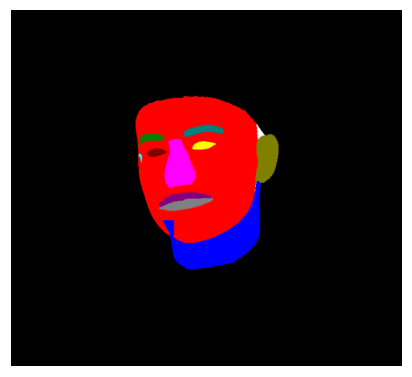

In [6]:
%matplotlib inline
Image.init_from_channels_at_back(rendered_image).view()

In [11]:
vertex_scaled = vertex_projected.T[:,:2]
# the image coordinate system is a bit different from us.
# the origin of an image is indeed (0, image_height)
vertex_scaled[:, 1] = canvas_height-vertex_scaled[:, 1]
vertex_scaled = vertex_scaled * 2. / [canvas_width, canvas_height] - 1.
tf_vertices = tf.concat([vertex_scaled, tf.zeros([n_vertex, 1]), tf.ones([n_vertex, 1])], axis=1)

tf_tri = tf.constant(tri, dtype=tf.int32)

# segmentation mask in color
vertex_colors = np.ones((n_vertex,n_channel))
for key in mask_annotation:
    if mask_annotation[key]['part_name'] not in ['left_backhead_patch', 'right_backhead_patch']:
        vertex_colors[mask_annotation[key]['v_index']] = rgb_index2color[key]/255.0
vertex_colors = tf.constant(vertex_colors, dtype=tf.float32)

# bg = tf.constant(image.astype(np.float32)/255.0)
# bg = tf.zeros_like(image, dtype=tf.float32)
bg = tf.zeros((canvas_height, canvas_width, vertex_colors.shape[1]), dtype=tf.float32)

pixels = dirt.rasterise(
            vertices=tf_vertices,
            faces=tf_tri,
            vertex_colors=vertex_colors,
            background=bg,
            height=canvas_height, width=canvas_width, channels=n_channel
         )

with tf.Session() as sess:
    rendered_image = sess.run([pixels])
    rendered_image = rendered_image[0]

In [ ]:
dirt.rasterise_batch()

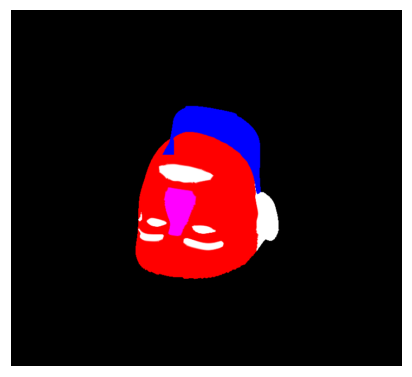

In [12]:
%matplotlib inline
Image.init_from_channels_at_back(rendered_image).view()